Data loaded successfully from /content/Train_data.csv
Data loaded successfully from /content/Test_data.csv
Data has 25192 rows and 42 columns.
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0               

<ipython-input-2-23eb9f8a3603>:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
<ipython-input-2-23eb9f8a3603>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Data cleaning completed.


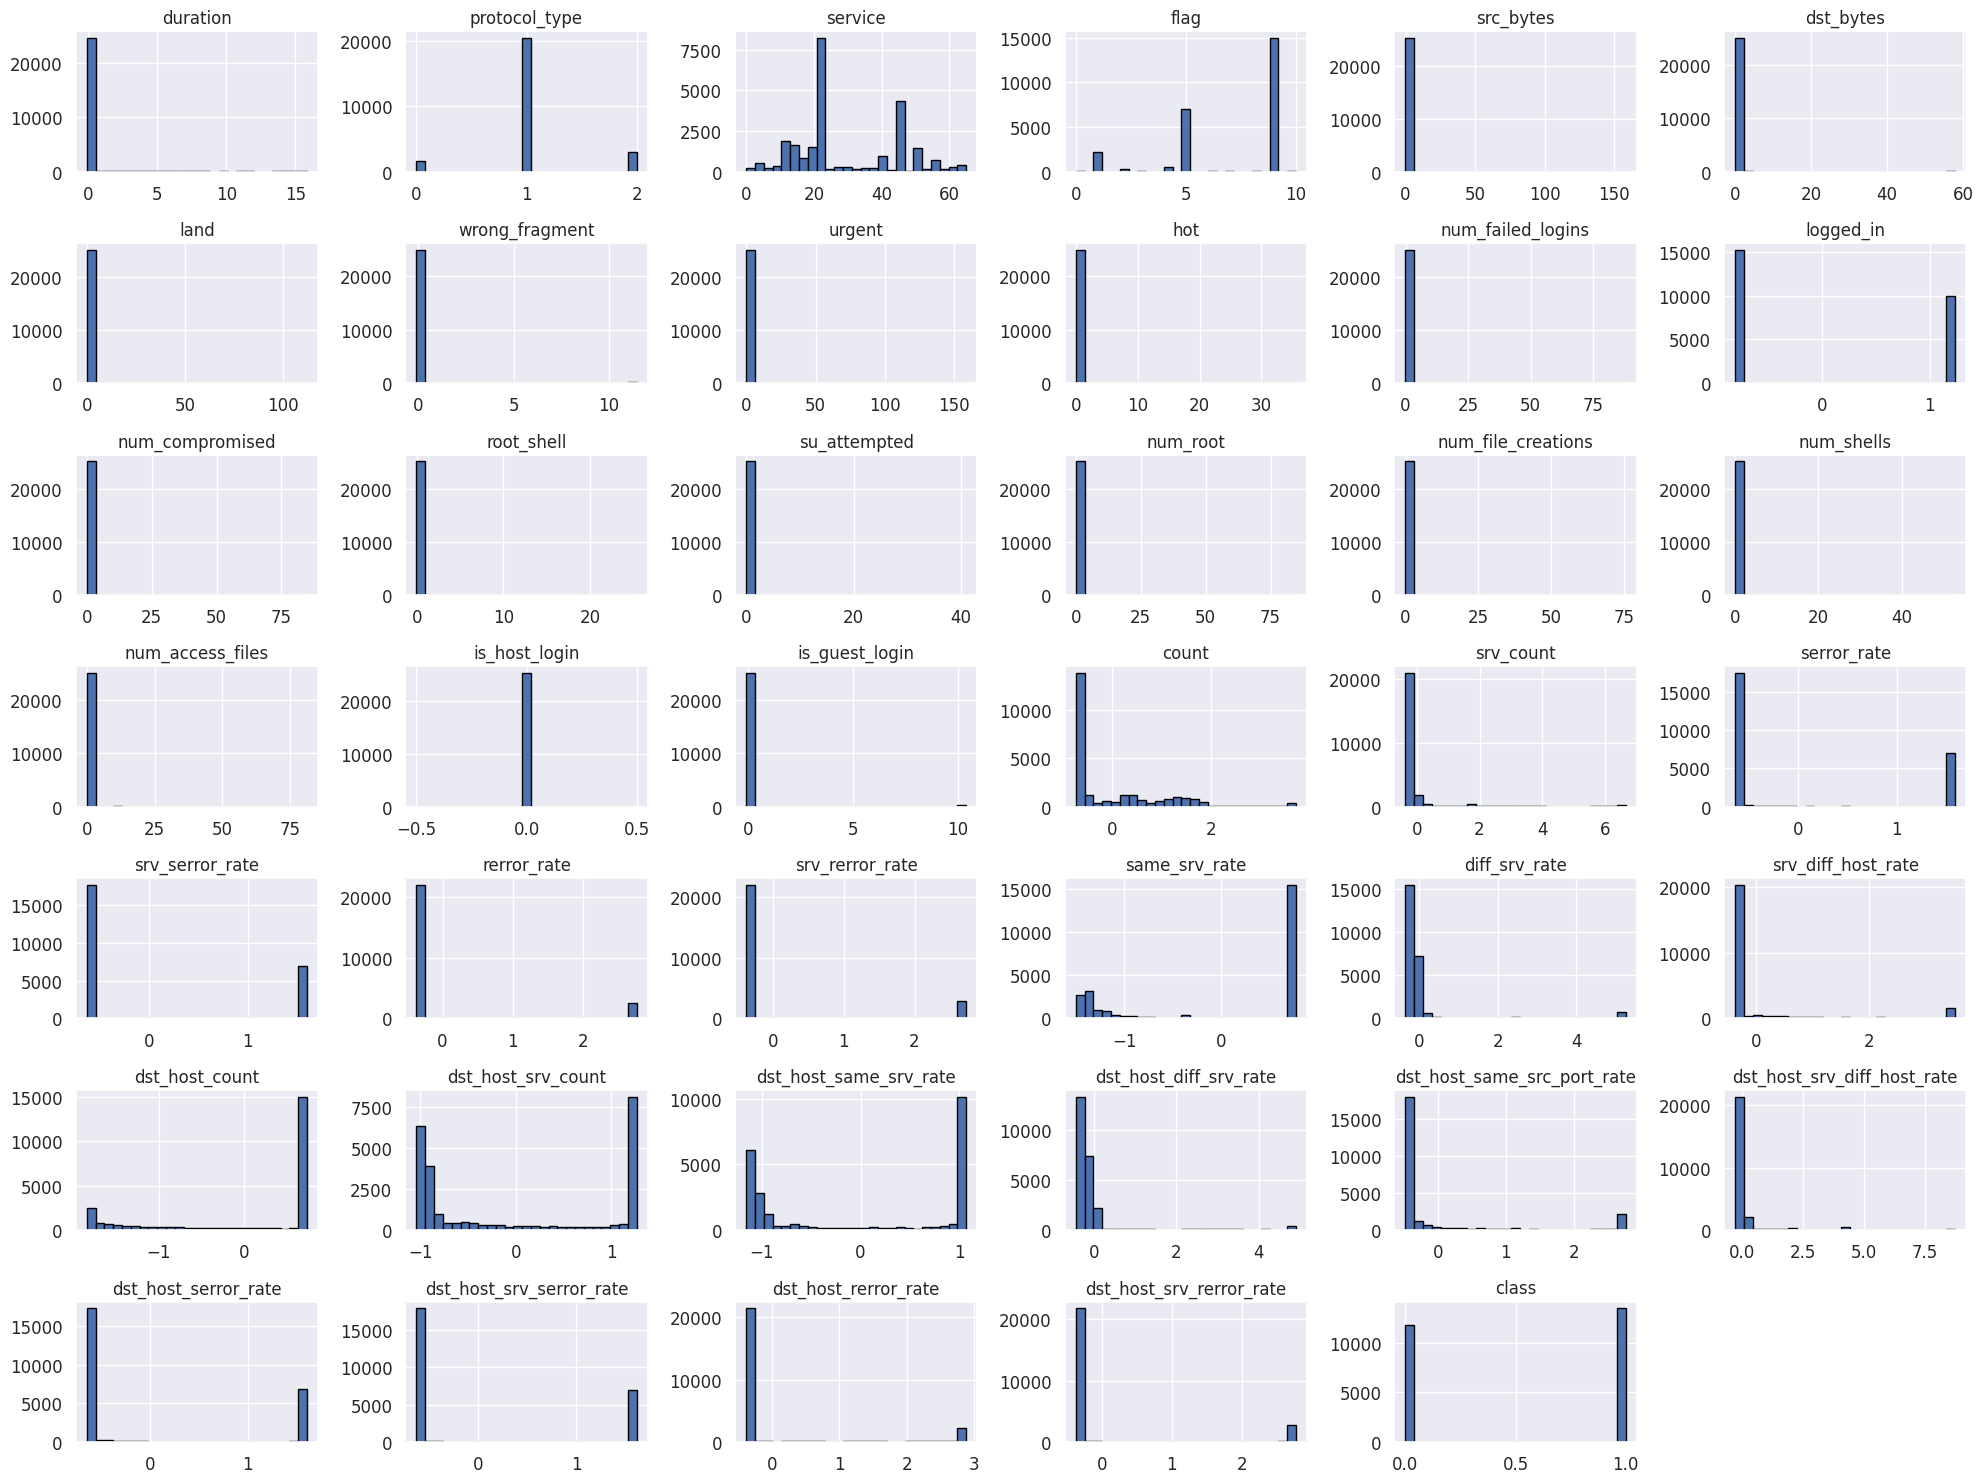

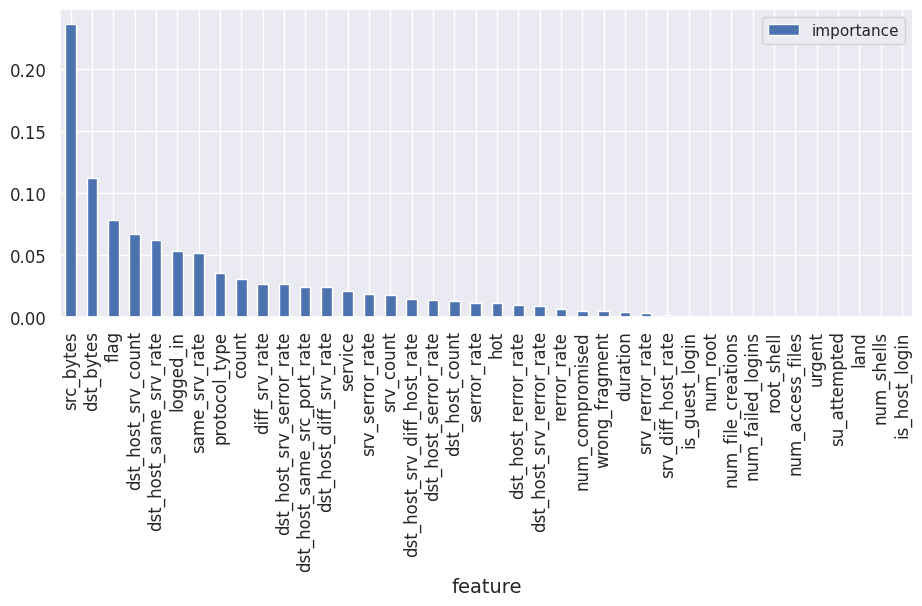

KNN Accuracy: 0.9885
Logistic Regression Accuracy: 0.9455
Naive Bayes Accuracy: 0.8833
Decision Tree Accuracy: 0.9951
SVM Accuracy: 0.9458
Data saved to database successfully.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
import sqlite3
import os

# Settings
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def load_data(file_path):
    """Loads dataset and handles potential errors."""
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except pd.errors.EmptyDataError:
        print(f"Error: No data found in the file at {file_path}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    return None

def explore_data(df):
    """Displays basic information about the dataset."""
    if df is not None:
        print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns.")
        print(df.head())
        print(df.info())

def clean_data(df):
    """Cleans dataset by handling missing values and redundant columns."""
    try:
        redundant_cols = ['num_outbound_cmds'] if 'num_outbound_cmds' in df.columns else []
        df.drop(columns=redundant_cols, inplace=True, errors='ignore')

        for col in df.columns:
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col].fillna(df[col].mean(), inplace=True)
        print("Data cleaning completed.")
        return df
    except Exception as e:
        print(f"Error during data cleaning: {e}")
    return df

def scale_features(df):
    """Applies feature scaling to numerical columns."""
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

def encode_categorical(df):
    """Encodes categorical variables using Label Encoding."""
    encoder = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = encoder.fit_transform(df[col])
    return df

def plot_histograms(df):
    """Plots histograms for numerical columns."""
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numerical_columns].hist(figsize=(20, 15), bins=25, edgecolor='black')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(df_x, df_y):
    """Plots feature importance using RandomForestClassifier."""
    rfc = RandomForestClassifier()
    rfc.fit(df_x, df_y)
    importances = pd.DataFrame({'feature': df_x.columns, 'importance': rfc.feature_importances_})
    importances = importances.sort_values('importance', ascending=False).set_index('feature')
    importances.plot.bar(figsize=(11, 4))
    plt.show()

def feature_selection(df_x, df_y):
    """Performs feature selection using Recursive Feature Elimination (RFE)."""
    rfc = RandomForestClassifier()
    rfe = RFE(rfc, n_features_to_select=15)
    rfe.fit(df_x, df_y)
    selected_features = df_x.columns[rfe.support_]
    return selected_features

def split_data(df_x, df_y):
    """Splits the dataset into training and test sets."""
    return train_test_split(df_x, df_y, train_size=0.70, random_state=42)

def train_classifiers(X_train, Y_train, X_test, Y_test):
    """Trains multiple classifiers and evaluates their performance."""
    models = {
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=0),
        'Naive Bayes': BernoulliNB(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(kernel='linear', random_state=0)
    }

    for name, model in models.items():
        model.fit(X_train, Y_train)
        score = model.score(X_test, Y_test)
        print(f"{name} Accuracy: {score:.4f}")

def save_to_db(df, db_name='processed_data.db'):
    """Saves processed dataset to SQLite database."""
    try:
        conn = sqlite3.connect(db_name)
        df.to_sql('cleaned_data', conn, if_exists='replace', index=False)
        print("Data saved to database successfully.")
    except Exception as e:
        print(f"Error saving data: {e}")
    finally:
        conn.close()

def main():
    """Executes the complete machine learning pipeline."""
    train_data = load_data("/content/Train_data.csv")
    test_data = load_data("/content/Test_data.csv")

    explore_data(train_data)

    train_data = clean_data(train_data)
    test_data = clean_data(test_data)

    train_data = scale_features(train_data)
    test_data = scale_features(test_data)

    train_data = encode_categorical(train_data)
    test_data = encode_categorical(test_data)

    df_x = train_data.drop(['class'], axis=1)
    df_y = train_data['class']
    selected_features = feature_selection(df_x, df_y)

    plot_histograms(train_data)
    plot_feature_importance(df_x, df_y)

    X_train, X_test, Y_train, Y_test = split_data(df_x[selected_features], df_y)

    train_classifiers(X_train, Y_train, X_test, Y_test)

    save_to_db(train_data)

if __name__ == "__main__":
    main()
